# Analysis of Utrecht Supplemental Data

In [2]:
import logging
from pathlib import Path
import numpy as np
import os
import pandas as pd
import sys

from eztrack.fragility import lds_raw_fragility, state_perturbation_derivative
from eztrack.io import read_derivative_npy
from eztrack.io.base import _add_desc_to_bids_fname
from eztrack import preprocess_ieeg
from eztrack.utils import logger
import mne
from mne.utils import warn
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids, get_entities_from_fname

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../')
from sickkids.read import load_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Define Paths

In [3]:
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/ds003400/")
deriv_root = root / "derivatives" / "1000Hz" / "radius1.25"
figures_path = deriv_root / "figures"

In [15]:
# define BIDS entities
SUBJECTS = [
    'RESP0059',
    'RESP0280',
    'RESP0301',
    'RESP0356',
    'RESP0384',
]

# extraop-moved around electrodes, preresection, post
SESSIONS = [
    "SITUATION1A", "SITUATION1B",
    "SITUATION2A",
    "SITUATION3A",
    "SITUATION4A"
]

task = 'acute'
datatype = "ieeg"
extension = ".vhdr"

# analysis parameters
reference = "monopolar"
order = 1
resample_sfreq = 1000
overwrite = True
verbose = False

In [5]:
subject = SUBJECTS[0]
session = SESSIONS[0]

# create path for the dataset
bids_path = BIDSPath(
    subject=subject,
    session=session,
    task=task,
    # run=run,
    datatype=datatype,
    # acquisition=acquisition,
    suffix=datatype,
    root=root,
    extension=extension,
)
print(f"Analyzing {bids_path}")

Analyzing /Users/adam2392/OneDrive - Johns Hopkins/ds003400/sub-RESP0059/ses-SITUATION1A/ieeg/sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.vhdr


# Load Data

In [6]:
raw = read_raw_bids(bids_path)

if resample_sfreq:
    # perform resampling
    raw = raw.resample(resample_sfreq, n_jobs=-1, verbose=verbose)

raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=False, exclude=[])
raw.drop_channels(raw.info['bads'])
raw.load_data()

print(raw)

Reading in coordinate system frame other: None.


<ipython-input-6-79e8217d9379>:1: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input other
  raw = read_raw_bids(bids_path)


<RawBrainVision | sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.eeg, 25 x 324994 (325.0 s), ~62.0 MB, data loaded>


In [7]:
print(raw.ch_names)
print(raw.info)

['Gr16', 'Gr17', 'Gr18', 'Gr19', 'Rst01', 'Rst02', 'Rst03', 'Gr11', 'Gr12', 'Gr13', 'Gr14', 'Gr15', 'Rst04', 'Rst05', 'Rst06', 'Gr06', 'Gr07', 'Gr08', 'Gr09', 'Gr10', 'Gr01', 'Gr02', 'Gr03', 'Gr04', 'Gr05']
<Info | 9 non-empty values
 bads: []
 ch_names: Gr16, Gr17, Gr18, Gr19, Rst01, Rst02, Rst03, Gr11, Gr12, Gr13, ...
 chs: 25 ECOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 line_freq: 50
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 25
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 11 items (dict)
>


In [8]:
print(raw.info['subject_info'])

{'participant_id': 'sub-RESP0059', 'sex': 2, 'age': '15,0', 'coverage': 'T', 'side': 'R', 'type iEEG': 'aECoG', 'type surgery': 'Right anterior temporal lobectomy including hippocampectomy', 'lobe surgery': 'T', 'pathology': 'MTS, Wyler gr 4 + basotemporal neocortical reactive tissue', 'engel 1 year': '1A', 'aed': 'unknown'}


In [9]:
# pre-process the data using preprocess pipeline
print("Power Line frequency is : ", raw.info["line_freq"])
l_freq = 0.5
h_freq = 300
raw = preprocess_ieeg(raw, l_freq=l_freq, h_freq=h_freq, verbose=verbose)

Power Line frequency is :  50


# Fragility Analysis

In [10]:
# get the root derivative path
deriv_chain = Path("fragility") / reference / f"sub-{subject}"
raw_figures_path = root / "derivatives" / "figures" / "raw" / f"sub-{subject}"
figures_path = figures_path / deriv_chain
deriv_path = deriv_root / deriv_chain

# check if we have original dataset
source_basename = bids_path.copy().update(extension=None, suffix=None).basename
deriv_fpaths = deriv_path.glob(f"{source_basename}*.npy")
if not overwrite and len(list(deriv_fpaths)) > 0:
    warn(
        f"Not overwrite and the derivative file path for {source_basename} already exists. "
        f"Skipping..."
    )

In [21]:
print(f"Analyzing {raw} with {len(raw.ch_names)} channels.")

order = 1
l2penalty = raw.get_data().min() * 1e-2
print(f"Data l2 penalty: {l2penalty}")
l2penalty = 1e-9
# l2penalty = 1
print(f"Going to use l2penalty: {l2penalty}")
model_params = {
    "winsize": 500,
    "stepsize": 250,
    "radius": 1.25,
    "method_to_use": "pinv",
    # "fb": True,
    "l2penalty": l2penalty,
}
# run heatmap
perturb_deriv, state_arr_deriv, delta_vecs_arr_deriv = lds_raw_fragility(
    raw,
    order=order,
    reference=reference,
    return_all=True,
    **model_params,
    # progress_file='./test.txt'
)

Fragility Heatmap:   0%|          | 0/1298 [00:00<?, ?eeg window/s]

Analyzing <RawBrainVision | sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.eeg, 25 x 324994 (325.0 s), ~62.0 MB, data loaded> with 25 channels.
Data l2 penalty: -0.0004421483829336551
Going to use l2penalty: 1e-09
Using pinv least squares with l2penalty 1e-09.
Data matrix shape input: (25, 324994). Estimate state array with SystemIDModel(fit_intercept=True, l2penalty=1e-09, normalize=True) and compute perturbation with Structured Perturbation Model | radius=1.25, perturb_type=C.


Fragility Heatmap: 100%|██████████| 1298/1298 [00:10<00:00, 118.26eeg window/s]


(25,) (25, 25) (25, 25)


/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
# save the files
perturb_deriv_fpath = deriv_path / perturb_deriv.info._expected_basename
state_deriv_fpath = deriv_path / state_arr_deriv.info._expected_basename
delta_vecs_deriv_fpath = deriv_path / delta_vecs_arr_deriv.info._expected_basename

print("Saving files to: ")
print(perturb_deriv_fpath)
print(state_deriv_fpath)
print(delta_vecs_deriv_fpath)
perturb_deriv.save(perturb_deriv_fpath, overwrite=overwrite)
state_arr_deriv.save(state_deriv_fpath, overwrite=overwrite)
delta_vecs_arr_deriv.save(delta_vecs_deriv_fpath, overwrite=overwrite)

Saving files to: 
/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-perturbmatrix_ieeg
/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-statematrix_ieeg
/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-deltavecsmatrix_ieeg


/Users/adam2392/Documents/eztrack/eztrack/io/base.py:1551: RuntimeWarning: This filename (/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-perturbmatrix_ieeg) does not conform to MNE naming conventions. All derivative files should end with ieeg.npy or eeg.npy
  check_fname(fname, "derivative", ("ieeg.npy", "eeg.npy"))
/Users/adam2392/Documents/eztrack/eztrack/io/base.py:1551: RuntimeWarning: This filename (/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-statematrix_ieeg) does not conform to MNE naming conventions. All derivative files should end with ieeg.npy or eeg.npy
  check_fname(fname, "derivative", ("ieeg.npy", "eeg.npy"))
/Users/adam2392/Documents/eztrack/eztrack/io/base.py:1551: RuntimeWarning: This filename (/Users/adam2392/OneDrive - Johns Hopkins/ds003400/deri

PosixPath('/Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1A_task-acute_desc-deltavecsmatrix_ieeg')

# Plot Heatmaps

In [11]:
figures_path.mkdir(exist_ok=True, parents=True)
perturb_deriv.normalize()
fig_basename = perturb_deriv_fpath.with_suffix(".pdf").name

elecs_path = bids_path.copy().update(
    session='SITUATION1B',
    suffix="electrodes", extension=".tsv", task=None)

# read in sidecar channels.tsv
channels_pd = pd.read_csv(elecs_path.fpath, sep="\t")
description_chs = pd.Series(
    channels_pd.resected.values, index=channels_pd.name
).to_dict()
print(description_chs)
resected_chs = [
    ch
    for ch, description in description_chs.items()
    if description == "yes"
]
print(f"Resected channels are {resected_chs}")

NameError: name 'perturb_deriv' is not defined

saving figure to /Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/figures/fragility/monopolar/sub-RESP0059/fragility/monopolar/sub-RESP0059 sub-RESP0059_ses-SITUATION1A_task-acute_desc-perturbmatrix_ieeg.pdf


(<Figure size 1800x1800 with 2 Axes>,
 <AxesSubplot:title={'center':'sub-RESP0059_ses-SITUATION1A_task-acute_desc-perturbmatrix_ieeg.pdf'}, xlabel='Time (Secs)'>)

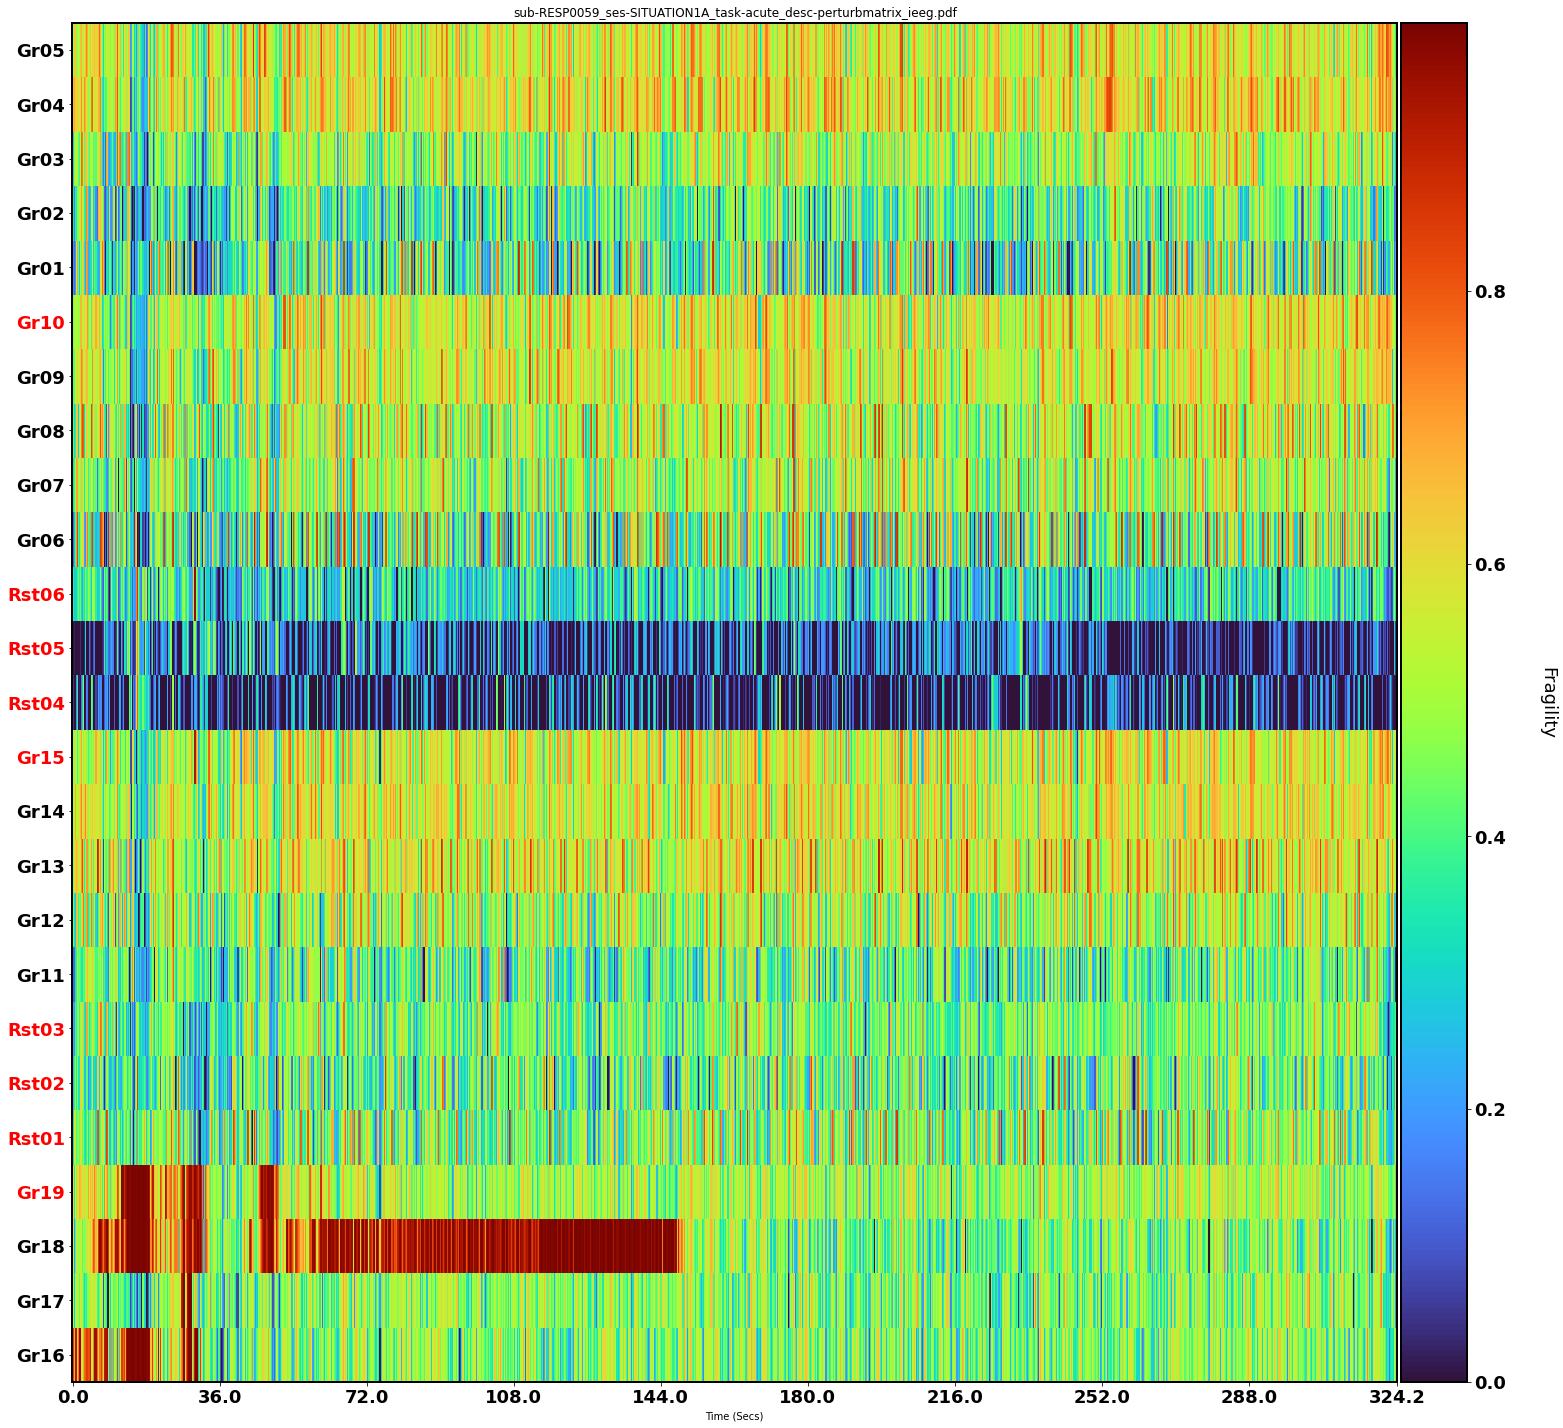

In [32]:

print(f"saving figure to {figures_path} {fig_basename}")
perturb_deriv.plot_heatmap(
    soz_chs=resected_chs,
    cbarlabel="Fragility",
    cmap="turbo",
    # vertical_markers=vertical_markers,
    # soz_chs=soz_chs,
    # figsize=(10, 8),
    # fontsize=12,
    # vmax=0.8,
    title=fig_basename,
#     figure_fpath=(figures_path / fig_basename),
)

In [12]:
print(raw.annotations)

event_name = 'artefact'
print(raw)
for annot in raw.annotations:
    if event_name == annot['description']:
        onset = annot['onset']
        duration = annot['duration']
        offset = onset + annot['duration']
        print(f'Removing raw data between {onset} and {offset}')
#     if event_name == 'good data segment':
    else:
        print(annot)
#     print(annot)

<Annotations | 20 segments: artefact (19), good data segment (1)>
<RawBrainVision | sub-RESP0059_ses-SITUATION1A_task-acute_ieeg.eeg, 25 x 324994 (325.0 s), ~62.0 MB, data loaded>
Removing raw data between 0.027344 and 39.544944
OrderedDict([('onset', 0.97656), ('duration', 323.4961), ('description', 'good data segment'), ('orig_time', None)])
Removing raw data between 4.9907 and 159.6191
Removing raw data between 7.9277 and 65.8808
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 26.8691 and 40.1518
Removing raw data between 27.3594 and 34.1758
Removing raw data between 27.3594 and 34.1758
Removing raw data between 27.3594 and 34.1758
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62

# Plot over looping of subjects and sessions

In [ ]:
print(raw.annotations)

event_name = 'artefact'
print(raw)
for annot in perturb_deriv.annotations:
    if event_name == annot['description']:
        onset = annot['onset']
        duration = annot['duration']
        offset = onset + annot['duration']
        print(f'Removing raw data between {onset} and {offset}')
#     if event_name == 'good data segment':
    else:
        print(annot)
#     print(annot)

In [12]:
# get the root derivative path
deriv_chain = Path("fragility") / reference / f"sub-{subject}"
figures_path = figures_path / deriv_chain
deriv_path = deriv_root / deriv_chain

/Users/adam2392/Documents/eztrack/eztrack/io/npy/npy.py:161: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input other
  raw = read_raw_bids(source_bids_path, verbose=verbose)
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


Removing raw data between 0.027344 and 39.544944
Removing raw data between 4.9907 and 159.6191
Removing raw data between 7.9277 and 65.8808
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 13.9023 and 19.4003
Removing raw data between 26.8691 and 40.1518
Removing raw data between 27.3594 and 34.1758
Removing raw data between 27.3594 and 34.1758
Removing raw data between 27.3594 and 34.1758
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62986999999998
Removing raw data between 231.9243 and 232.62986999999998
{'Gr16': 'yes', 'Gr17': 'yes', 'Gr18': 'yes', 'Gr19'

/Users/adam2392/Documents/eztrack/eztrack/io/npy/npy.py:161: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input other
  raw = read_raw_bids(source_bids_path, verbose=verbose)
/Users/adam2392/Documents/eztrack/eztrack/io/base.py:571: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  new_annotations.crop(
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


[]
Dont need to crop for <DerivativeNumpy | sub-RESP0059_ses-SITUATION1B_task-acute_desc-perturbmatrix_ieeg.npy, shape: (24, 1248) (24 chs x 1248 times) (311.8 s), ~284 kB, data loaded | reference=monopolar | perturbmatrix>
{'Gr16': 'no', 'Gr17': 'no', 'Gr18': 'no', 'Gr19': 'yes', 'Gr20': 'yes', 'Rst01': 'yes', 'Rst02': 'yes', 'Rst03': 'yes', 'Gr11': 'no', 'Gr12': 'no', 'Gr13': 'no', 'Gr14': 'no', 'Gr15': 'yes', 'Rst04': 'yes', 'Rst05': 'yes', 'Rst06': 'yes', 'Gr06': 'no', 'Gr07': 'no', 'Gr08': 'no', 'Gr09': 'no', 'Gr10': 'yes', 'Riv01': nan, 'Riv02': nan, 'Riv03': nan, 'Gr01': 'no', 'Gr02': 'no', 'Gr03': 'no', 'Gr04': 'no', 'Gr05': 'no', 'Riv04': nan, 'Riv05': nan, 'ECG': nan}
Resected channels are ['Gr19', 'Gr20', 'Rst01', 'Rst02', 'Rst03', 'Gr15', 'Rst04', 'Rst05', 'Rst06', 'Gr10']
saving figure to /Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/figures/fragility/monopolar/sub-RESP0059/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION1B_task

/Users/adam2392/Documents/eztrack/eztrack/io/npy/npy.py:161: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input other
  raw = read_raw_bids(source_bids_path, verbose=verbose)
/Users/adam2392/Documents/eztrack/eztrack/io/base.py:571: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  new_annotations.crop(
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


[]
Dont need to crop for <DerivativeNumpy | sub-RESP0059_ses-SITUATION2A_task-acute_desc-perturbmatrix_ieeg.npy, shape: (10, 1549) (10 chs x 1549 times) (387.0 s), ~146 kB, data loaded | reference=monopolar | perturbmatrix>
{'Gr16': nan, 'Gr17': nan, 'Gr18': nan, 'Gr19': nan, 'Gr20': nan, 'Rst01': 'no', 'Rst02': 'no', 'Rst03': 'no', 'Gr11': nan, 'Gr12': nan, 'Gr13': nan, 'Gr14': nan, 'Gr15': nan, 'Rst04': 'no', 'Rst05': 'no', 'Rst06': 'no', 'Gr06': nan, 'Gr07': nan, 'Gr08': nan, 'Gr09': nan, 'Gr10': nan, 'Riv01': 'no', 'Riv02': 'no', 'Riv03': 'no', 'Gr01': nan, 'Gr02': nan, 'Gr03': nan, 'Gr04': nan, 'Gr05': nan, 'Riv04': 'no', 'Riv05': 'no', 'ECG': nan}
Resected channels are []
saving figure to /Users/adam2392/OneDrive - Johns Hopkins/ds003400/derivatives/1000Hz/radius1.25/figures/fragility/monopolar/sub-RESP0059/fragility/monopolar/sub-RESP0059/sub-RESP0059_ses-SITUATION2A_task-acute_desc-perturbmatrix_ieeg.pdf


FileNotFoundError: The path you specified, "sub-RESP0059_ses-SITUATION3A_task-acute_desc-perturbmatrix_ieeg.json",does not exist.

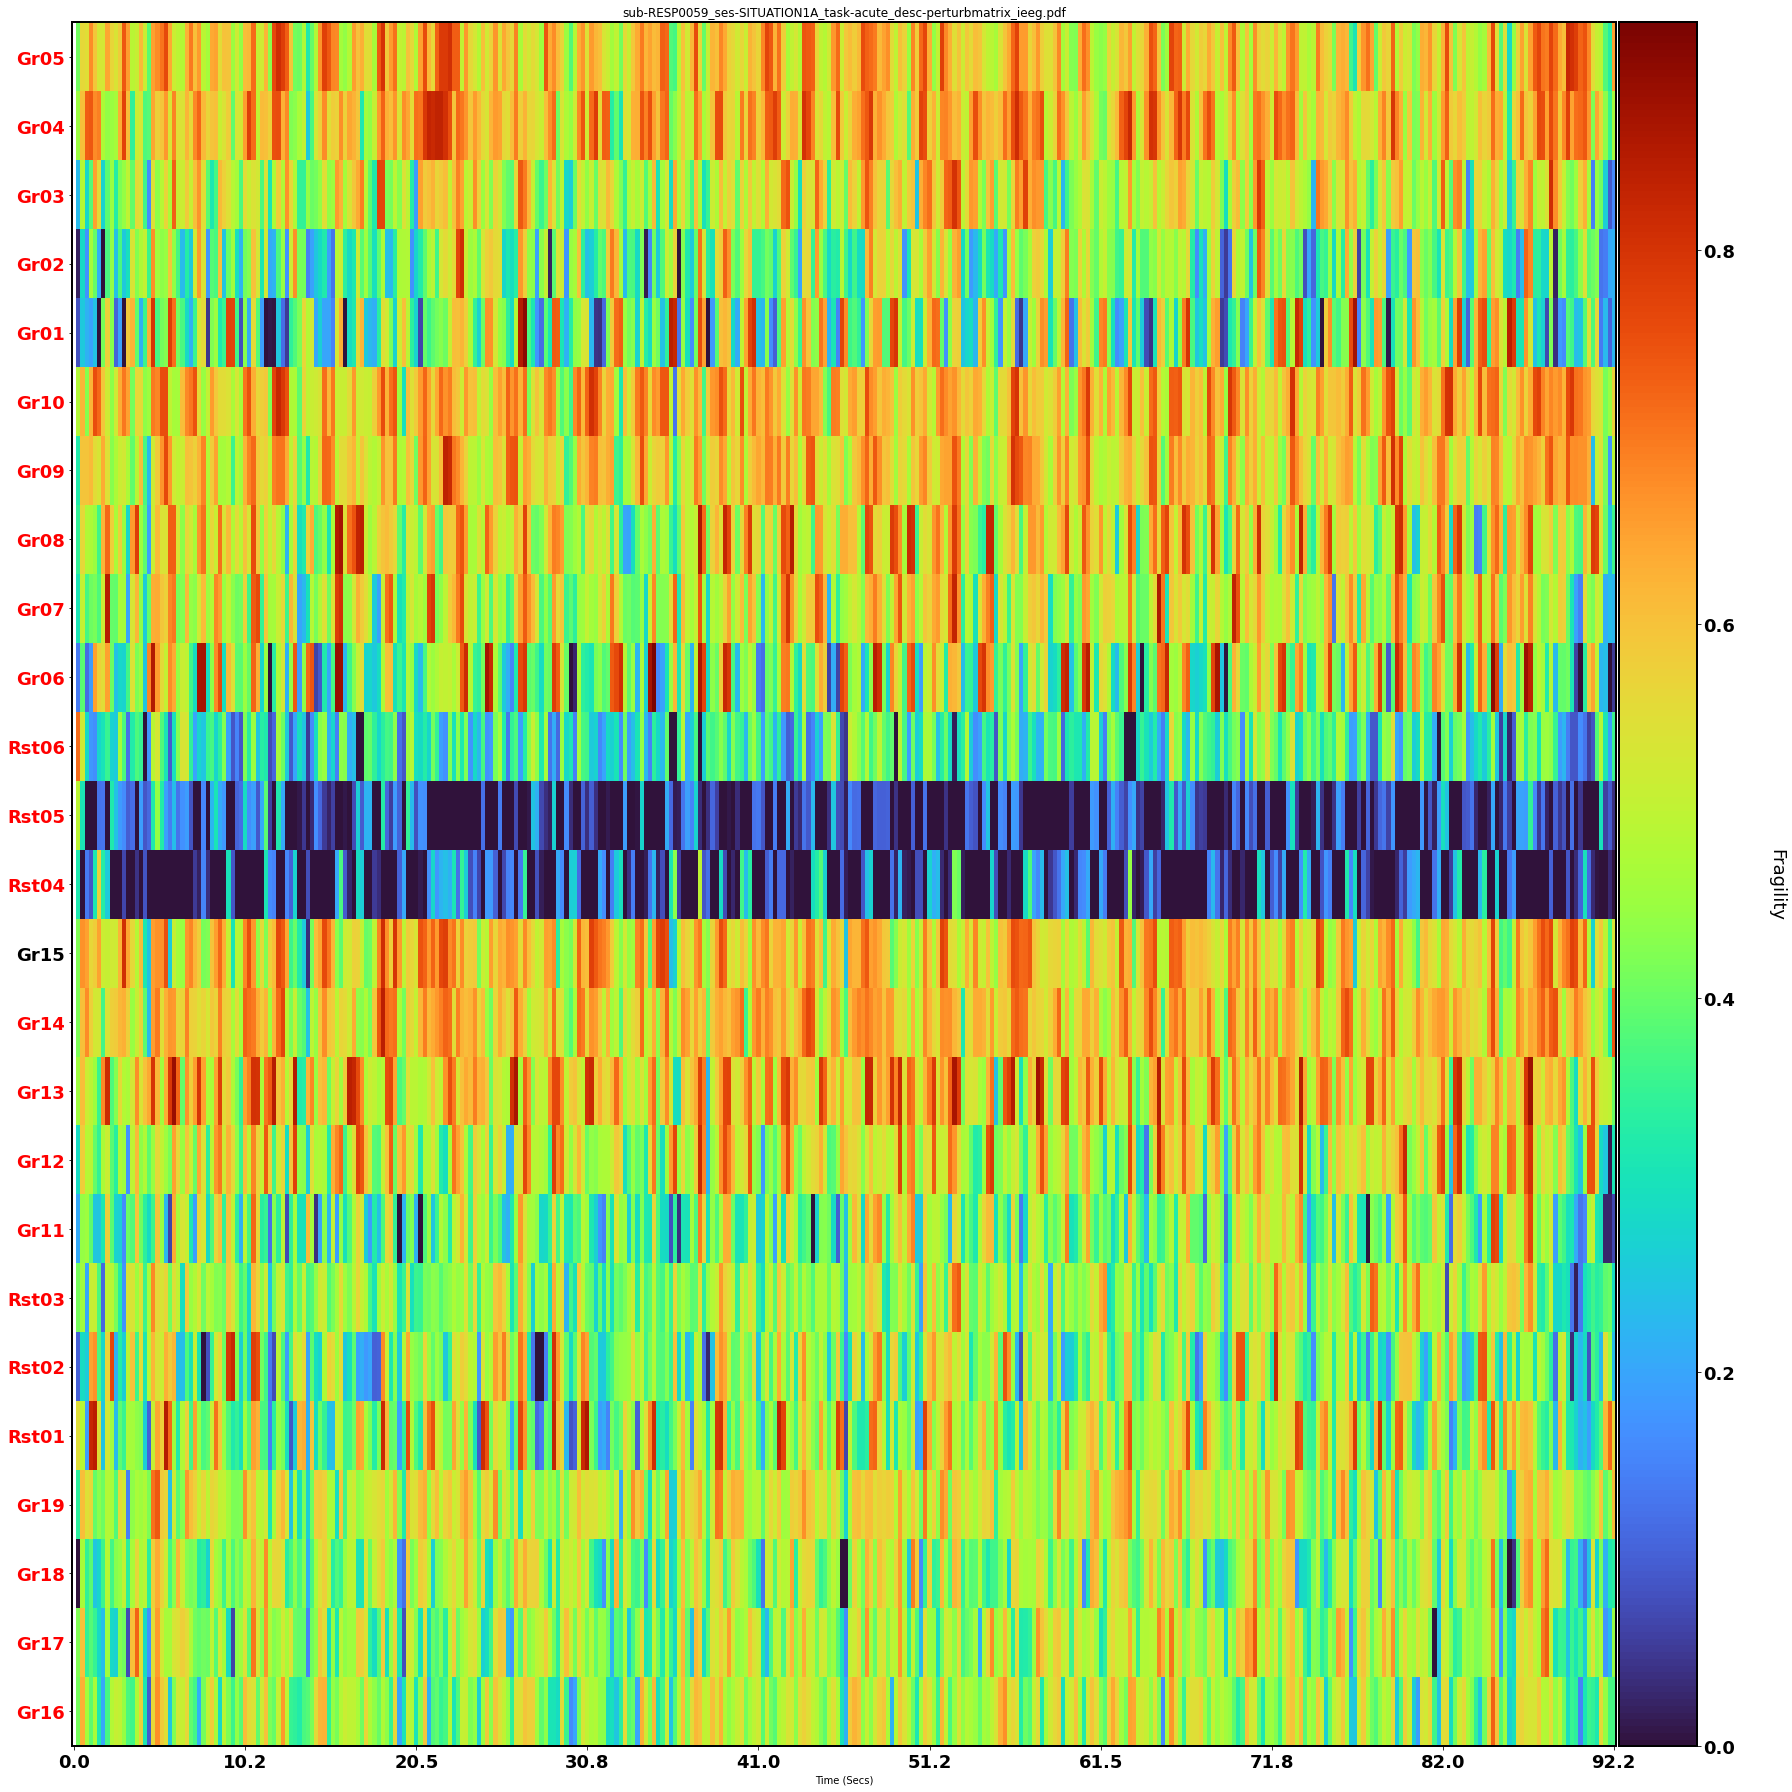

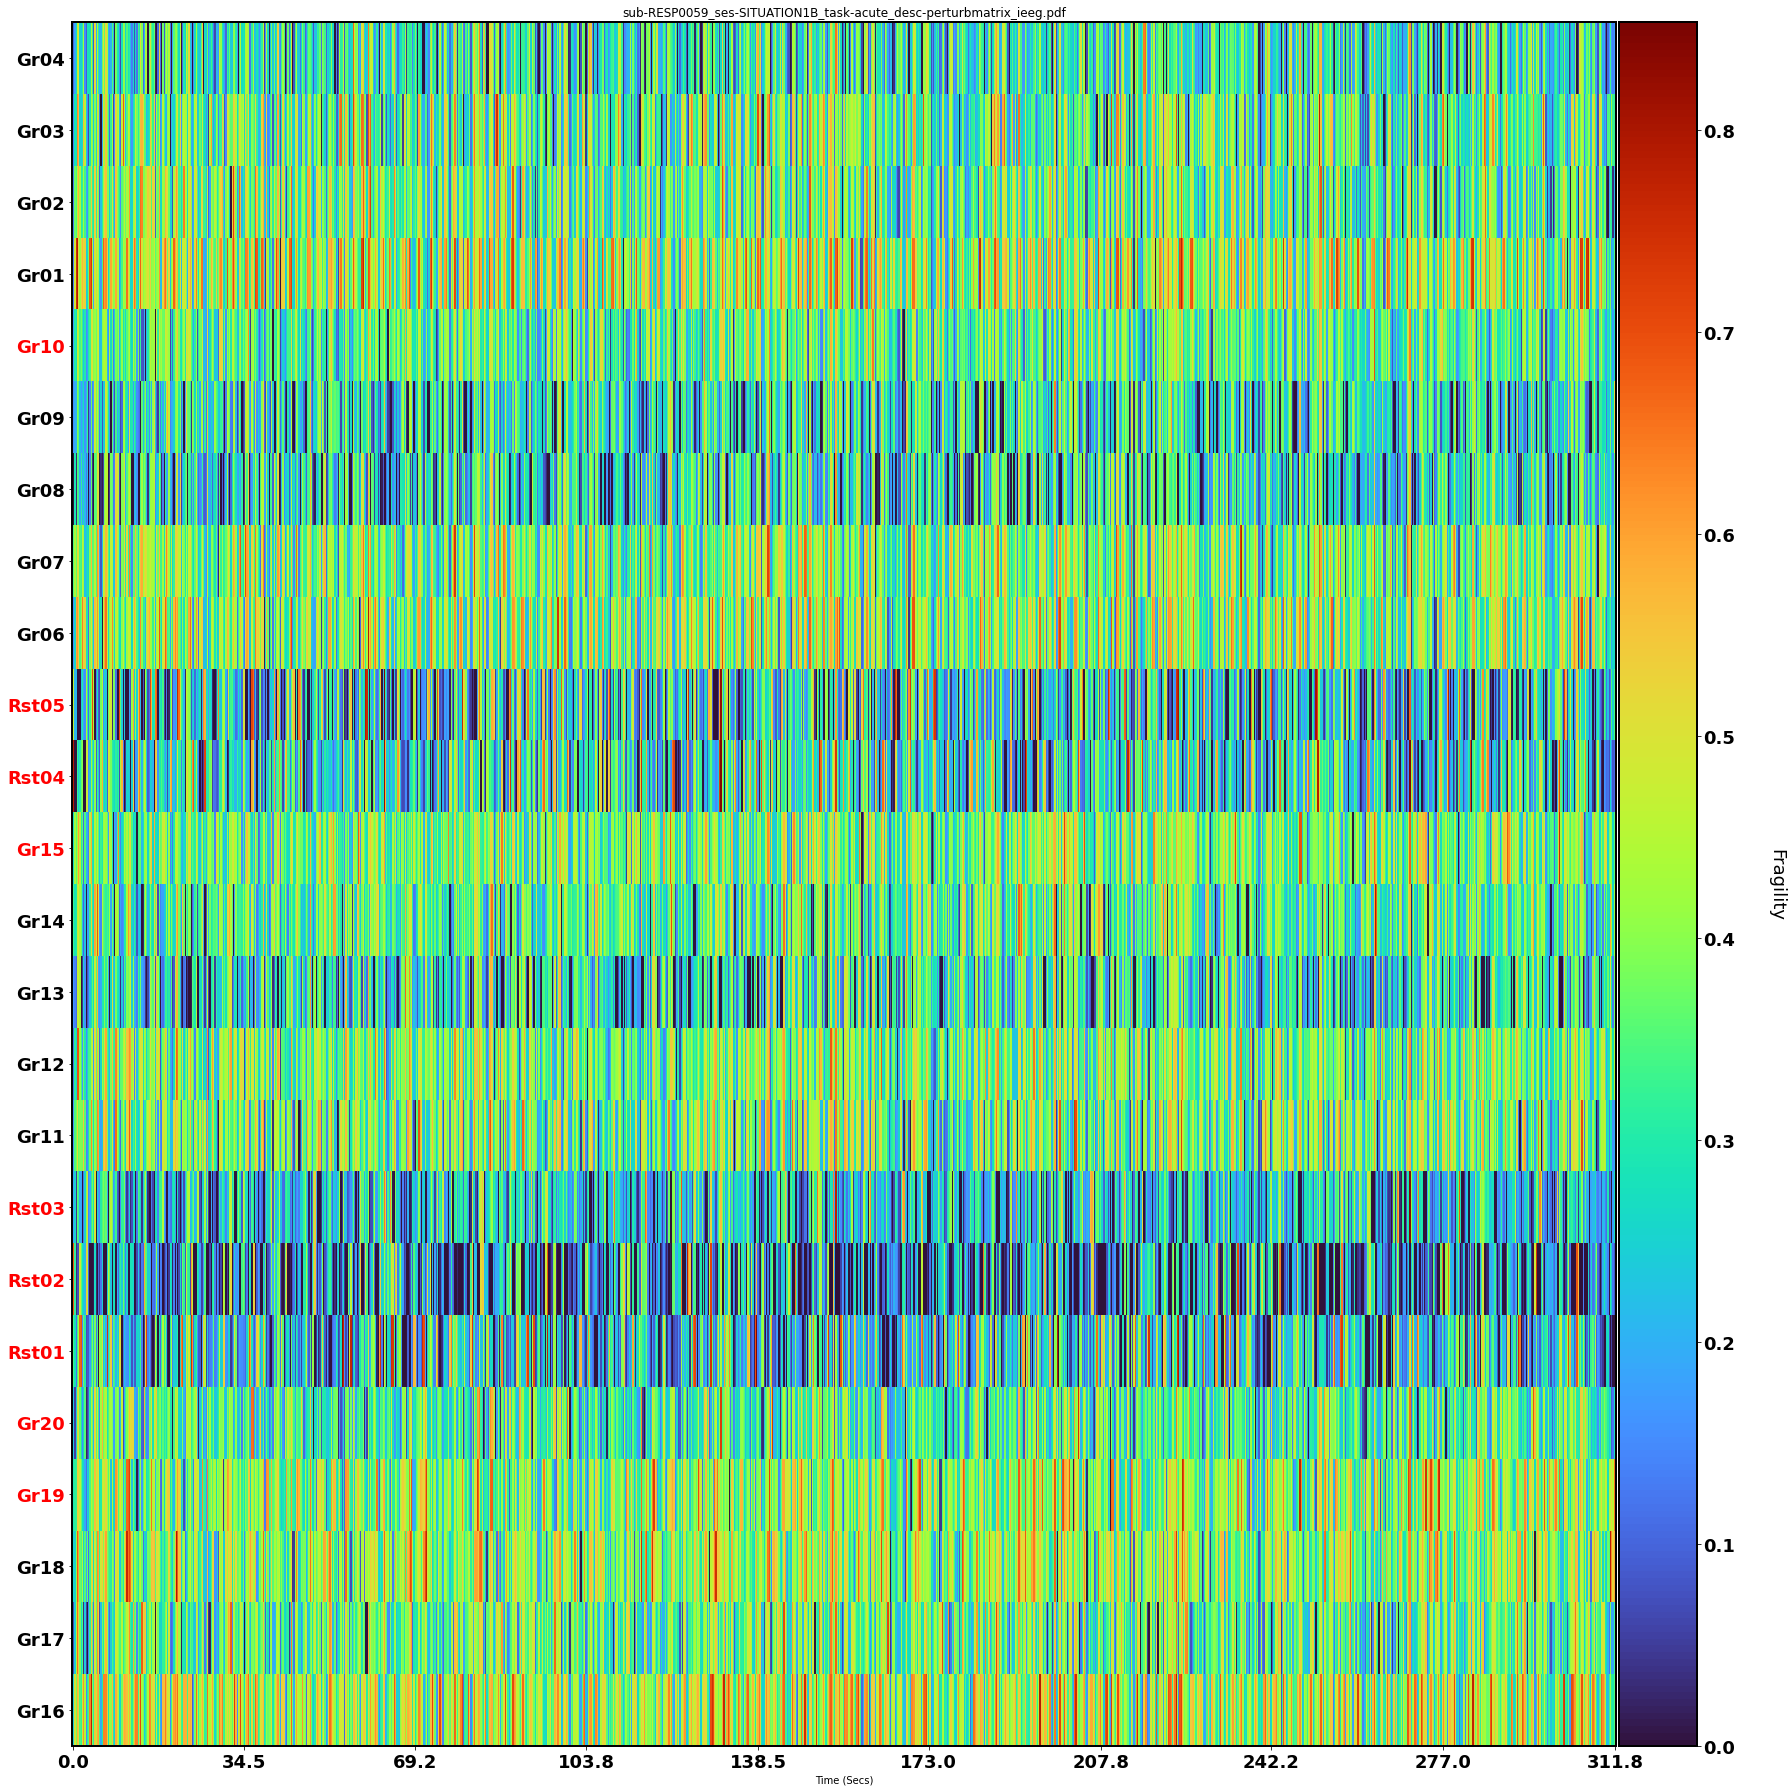

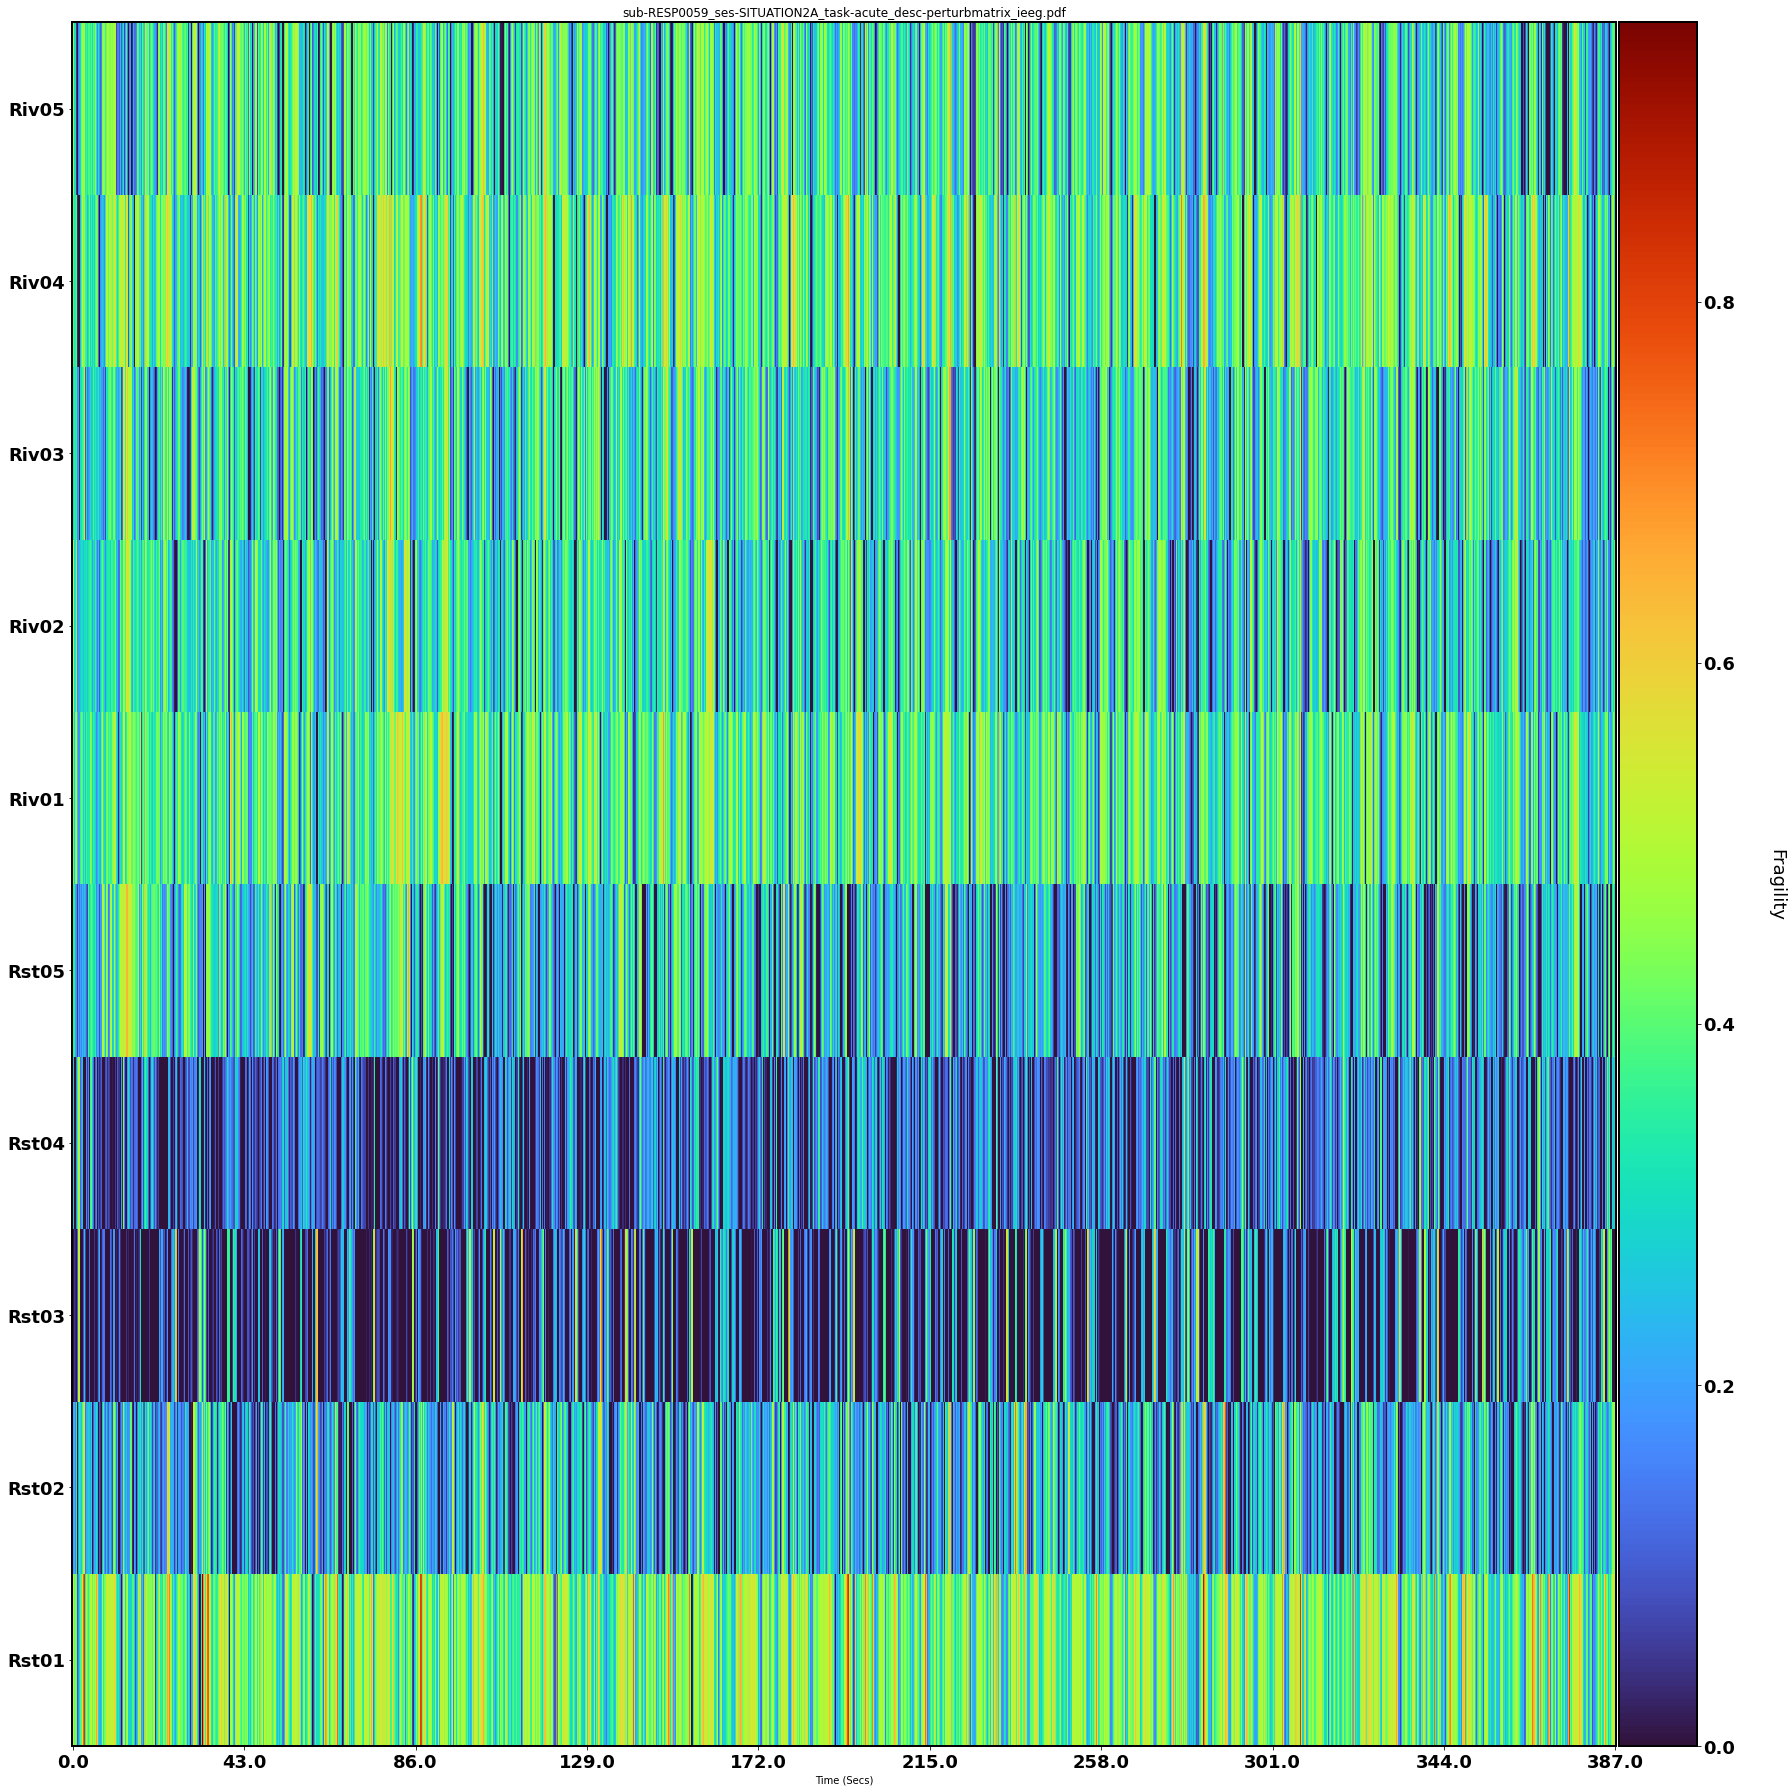

In [20]:
figures_path.mkdir(exist_ok=True, parents=True)

for session in SESSIONS:
    pert_deriv_fpath = deriv_path / _add_desc_to_bids_fname(bids_path.copy().update(
        extension='.npy', 
        session=session,
        check=False).basename, 'perturbmatrix')
    
    perturb_deriv = read_derivative_npy(pert_deriv_fpath, preload=True)
    
    # crop out the artifact regions
    event_name = 'artefact'
    for annot in perturb_deriv.annotations:
        if event_name == annot['description']:
            onset = annot['onset']
            duration = annot['duration']
            offset = onset + annot['duration']
            print(f'Removing raw data between {onset} and {offset}')
            perturb_deriv.apply_nan_to_epochs(onset, duration)
    nan_idx = np.where(np.isnan(perturb_deriv.get_data()))[1]
    if len(nan_idx) > 0:
        perturb_deriv.crop(tmin=nan_idx[-1] / perturb_deriv.info['sfreq'])
    else:
        print(nan_idx)
        print(f'Dont need to crop for {perturb_deriv}')
        
    
    # normalize data
    perturb_deriv.normalize()
    
    fig_basename = pert_deriv_fpath.with_suffix(".pdf").name

    elecs_path = bids_path.copy().update(
        session=session,
        suffix="electrodes", extension=".tsv", task=None)

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(elecs_path.fpath, sep="\t")
    description_chs = pd.Series(
        channels_pd.resected.values, index=channels_pd.name
    ).to_dict()
    print(description_chs)
    resected_chs = [
        ch
        for ch, description in description_chs.items()
        if description == "yes"
    ]
    print(f"Resected channels are {resected_chs}")


    print(f"saving figure to {figures_path}/{fig_basename}")
    perturb_deriv.plot_heatmap(
        soz_chs=resected_chs,
        cbarlabel="Fragility",
        cmap="turbo",
        # vertical_markers=vertical_markers,
        # soz_chs=soz_chs,
        # figsize=(10, 8),
        # fontsize=12,
        # vmax=0.8,
        title=fig_basename,
        figure_fpath=(figures_path / fig_basename),
    )
#     break

In [19]:
print(nan_idx)

[  0   1   2 ... 636 927 928]
